<a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![MAIA banner](https://raw.githubusercontent.com/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 2 <a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

<center><h1>Predicción y Control On-Policy</h1></center>

En este notebook tutorial vas a aprender sobre algunas técnicas <i>on-policy</i> que existen para aproximar la función de valor en un problema de aprendizaje por refuerzo y algoritmos de aprendizaje on-policy. Mostraremos el funcionamiento de estas técnicas y algoritmos utilizando el ambiente de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a>, incluido en las librerías de Gym. La misión central de este notebook es evidenciar de forma visual cómo se puede representar matemáticamente un problema y cómo se estructura una solución cuando se utilizan técnicas <i>on-policy</i>. El tutorial se divide en:


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con el Entorno de Gym](#scrollTo=Familiarizaci_n_con_el_Entorno_de_Gym)  
5. [Predicción on-policy](#scrollTo=Predicci_n_on_policy)  
6. [Control on-policy](#scrollTo=Control_on_policy)  
7. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
8. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  
  
* Conocer algunas formas matemáticas que se utilizan para representar problemas complejos de aprendizaje por refuerzo.
* Familiarizarse con los entornos de simulación de Gym.
* Entrenar y validar algoritmos de aprendizaje por refuerzo <i>on-policy</i> con aproximación de funciones (Deep SARSA).



# Marco Teórico  


El *tile coding* es un método de *coarse coding* adecuado para la computación digital secuencial y el aprendizaje en línea. Divide el espacio de entrada en múltiples *tilings* superpuestos, cada uno compuesto por *tiles* que representan características binarias. Esto garantiza un número fijo de características activas en todo momento, independientemente del estado de entrada, lo que facilita el ajuste de los parámetros de aprendizaje. El tamaño del paso (α) puede establecerse como *1/m*, donde m es el número de tilings, permitiendo actualizaciones eficientes.

El *tile coding* es computacionalmente eficiente, ya que las actualizaciones de la función de valor solo requieren sumar unos pocos pesos. Los *tilings* basados en cuadrículas simplifican el cálculo de índices, y los desplazamientos en múltiples *tilings* mejoran la generalización. Además, los *tilings* no uniformes permiten una representación adaptativa de las características, mientras que el hashing reduce el uso de memoria al mapear grandes *tilings* en un conjunto más pequeño de *tiles*, mitigando la maldición de la dimensionalidad sin afectar el rendimiento. [1]

La figura muestra cómo el tile coding divide un espacio de estados 2D en múltiples tilings superpuestos. La forma de los tiles afecta la generalización, mientras que el número de tilings determina la resolución de la aproximación final. Esto permite representar funciones de valor en aprendizaje por refuerzo con un equilibrio entre precisión y generalización.

![tile_coding](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/tile_coding.png)

<center>Figura 1. Representación gráfica de <i>tile coding</i>.</center>

La función de valor estado-acción en *tile coding* se expresa como la suma de los pesos de los *tiles* activados en diferentes *tilings*:  


 <center> $\hat{q}(s,a, \mathbf{w}) = \sum_{i=1}^{m} w_i x_i(s, a)$ </center>


donde $w_i$ son los pesos y $x_i(s, a)$ son variables binarias que indican los *tiles* activados para $(s, a)$.


Ahora, es necesario redirigir estos conceptos detrás de la aproximación de una función de valor al problema de control de política, es decir, al aprendizaje. Primero, recordemos que en el proceso de control de política un algoritmo busca construir una aproximación de la función de valor de acción $\hat{q}(s,a,\mathbf{w}) \approx q_*(s,a)$, donde $\mathbf{w}$ es un vector de tamaño finito con los pesos que definen la aproximación que se utilice. [1]

Para el caso de tareas episódicas, la extensión de los métodos de predicción de semi-gradiente a las funciones de valor de acciones es directa: $\hat{q}(s,a,\mathbf{w}) \approx q_{\pi}(s,a)$. Después, si se acoplan esas predicciones con técnicas de mejoramiento de política y selección de acciones, obtenemos el control de política. En tareas con un espacio de acciones discreto y relativamente pequeño, para cada posible acción $a$ posible en el siguiente estado $S_{t+1}$, se puede calcular $\hat{q}(S_{t+1},a,\mathbf{w}_t) \approx q_{\pi}(s,a)$ y encontrar la acción <i>greedy</i> ($A^*_{t+1} = \text{arg max}_a
 \hat{q}(s,a,\mathbf{w}))$. Para <i>algoritmos on-policy</i>, la política se mejora cambiando la política de estimación a una aproximación <i>soft</i> (que puede escoger cualquier acción) de la política <i>greedy</i> (que únicamente escoge la mejor acción). [1]

 La siguiente es la regla de actualización de SARSA de un paso, y el pseudoalgoritmo correspondiente se muestra en la Figura 2:



 <center>  $\mathbf{w}_{t+1} = \mathbf{w}_{t+1} + \alpha [R_{t+1} + \gamma \hat{q}(S_{t+1},a,\mathbf{w}_t) - \hat{q}(S_{t+1},a,\mathbf{w}_t) ] \nabla \hat{q}(S_{t+1},a,\mathbf{w}_t)$  &emsp;&emsp;&emsp;$(1)$ </center>


![SARSAnn](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/SARSA_dF.png)


<center>Figura 2. Algoritmo de SARSA con aproximación de funciones para control de política.</center>


# Instalación de Librerías  

Ejecute los siguientes bloques de código para instalar e importar las librerías requeridas en el tutorial. Aquí se instalan versiones compatibles de <i>keras</i>, <i>tensorflow</i> y <i>Gymnasium</i> para poder realizar los entrenamientos de SARSA con redes neuronales. La primera ejecución puede demorar un par de minutos en finalizar. Si la segunda celda le da un error, pruebe volver a ejecutar la celda.

In [66]:
#Instala librerías
!pip install gymnasium #entorno de simulación
!pip install renderlab #libtería para renderizar

#importa librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import renderlab #importa renderlab para videos
import gymnasium #importa gymnasium

#limpia registros
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido importadas correctamente.")

Todas las librerías han sido importadas correctamente.


# Familiarización con el Entorno de Gym

El ambiente de Gym de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a> consiste de un carro atrapado en el fondo de un valle, y debe acelerar a la izquierda o a la derecha para intentar ganar el impulso suficiente para salir. Puede leer más detalladamente la documentación de este ambiente en los foros oficiales de Gymnasium.

![Observation_space_cartpole](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Observation_space_mountaincar.png)

<center>Figura 5. Espacio de observación del ambiente de <i>Mountain Car</i>. [3]</center>

El espacio de estados del ambiente está definido en 2 dimensiones continuas, que definen la posición en el eje x y la velocidad del vehículo. Los límites de ambas variables puede observarse en la Figura 5. Por otra parte, el espacio de acciones consiste simplemente en 3 acciones discretas y determinísticas:

*   0: Acelera a la izquierda
*   1: No acelera
*   2: Acelera a la derecha

En este ambiente, el agente recibe una recompensa cuando alcanza una meta por fuera del valle, y por cada paso de tiempo que le toma alcanzarla recibe una recompensa negativa de -1. Si el auto llega a la meta (posición mayor a 0.5), el episodio se da por terminado, mientras que si el episodio supera los 200 pasos, se da por truncado; finalizando la simulación. Esto quiere decir que la peor recompensa posible será -200.


## Ejemplo

En esta sección se muestra un ejemplo de simulación de un episodio del <i>Mountain Car</i>. En este caso, el carro alterna acelerar a la izquierda y a la derecha en cada paso de tiempo.

In [67]:
#Ejemplo de simulación de un episodio de Mountain Car
env_prueba_1 = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
env_prueba_1 = renderlab.RenderFrame(env_prueba_1, "./output") #Se crea una copia que se pueda renderizar con renderlab

obs , info = env_prueba_1.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
terminated = False #Inicializa una condición para el loop
truncated = False #Inicializa una condición para el loop
total_reward=0 #Inicializa contador del retorno
action=0 #Inicializamos una variable de acción para alternar la selección

while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

  #Decide una acción. En este caso alterna entre izquierda y derecha
  if(action==0):
    action=2
  else:
    action=0

  obs, reward, terminated, truncated , info = env_prueba_1.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
  total_reward+=reward #Llevamos una cuenta de la recompensa total

print("Recompensa obtenida en el episodio:",total_reward) #Se imprime la recompensa obtenida
print("\n\n")

env_prueba_1.play() #Con esta función se obtiene el video de la simulación

Recompensa obtenida en el episodio: -200.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Puede observar que el retorno obtenido fue de -200, la peor recompensa posible. Alternar inmediatamente entre izquierda y derecha no es una estrategia útil.

## Ejercicio Práctico

Ahora, para comprobar el entendimiento y familiarización con el ambiente, intente por unos pocos minutos generar manualmente alguna estrategia para hacer que el carro logre salir del pozo (este será el problema que solucionaremos después con redes neuronales).

In [68]:
# Genere alguna estrategia para intentar salir del pozo.

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Predicción on-policy

En esta sección se busca revisar la implementación de técnicas de aproximación de la función de valor $q(s,a,\mathbf{w})$. Implementaremos dos métodos lineales: <i>Tile Coding</i> y Bases de Fourier. A continuación, se encuentran ya programadas una serie de clases que permiten aplicar ambas técnicas de aproximación de funciones al problema de <i>Mountain Car</i>. Específicamente, la implementación de <i>Tile Coding</i> fue tomada directamente del repositorio de Richard Sutton [3].  

## Código de Tiles

In [69]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed.
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)),
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))

In [70]:
# Tile Coding Class
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles

    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.

        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        array_tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        POSITION_MIN = -1.2
        POSITION_MAX = 0.6
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07

        # Scale position and velocity by multiplying the inputs of each by their scale
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)

        # Obtain active tiles for current position and velocity
        array_tiles = tiles(self.iht, self.num_tilings, [position * position_scale, velocity * velocity_scale])

        return np.array(array_tiles)

## Código de Bases de Fourier

In [71]:
class FourierBasis:
    def __init__(self, order, state_dim):
        self.order = order
        self.state_dim = state_dim
        self.coefficients = np.array(
            np.meshgrid(*[range(order + 1)] * state_dim)
        ).T.reshape(-1, state_dim)

    def get_features(self, state):
        return np.cos(np.pi * np.dot(self.coefficients, state))

## Ejemplo de Uso

El uso de las anteriores funciones se demuestra a continuación. En las siguientes celdas se puede observar cómo se obtienen las <i>tiles</i> y la Base de Fourier para un estado dado.

In [72]:
# Probamos la codificación en Tiles para el problema de Mountain Car
mctc = MountainCarTileCoder(iht_size = 1024, num_tilings = 8, num_tiles = 8)

# Revisamos la codificación para valores de posición y velocidad específicos
pos=-1
vel=0.02
array_tiles = mctc.get_tiles(position = pos, velocity = vel)
print(f"La codificación de Tiles para ({pos}, {vel}) es: {array_tiles}")

La codificación de Tiles para (-1, 0.02) es: [0 1 2 3 4 5 6 7]


In [73]:
# Probamos la codificación en Bases de Fourier para el problema de Mountain Car
mcfb = FourierBasis(order = 5, state_dim = 2)

# Revisamos la codificación para valores de posición y velocidad específicos
pos=-1
vel=0.02
array_fourier = mcfb.get_features(state=[pos,vel])
print(f"La codificación de Bases de Fourier para ({pos}, {vel}) es: \n {array_fourier}")

La codificación de Bases de Fourier para (-1, 0.02) es: 
 [ 1.          0.99802673  0.9921147   0.98228725  0.96858316  0.95105652
 -1.         -0.99802673 -0.9921147  -0.98228725 -0.96858316 -0.95105652
  1.          0.99802673  0.9921147   0.98228725  0.96858316  0.95105652
 -1.         -0.99802673 -0.9921147  -0.98228725 -0.96858316 -0.95105652
  1.          0.99802673  0.9921147   0.98228725  0.96858316  0.95105652
 -1.         -0.99802673 -0.9921147  -0.98228725 -0.96858316 -0.95105652]


# Control on-policy

En este apartado se busca utilizar las representaciones anteriormentes vistas del problema de <i>Mountain Car</i> en <i>Tiles</i> y en Bases de Fourier como herramientas en el entrenamiento del algoritmo de SARSA.  Luego, se busca revisar el efecto que tienen los cambios de hiperparámetros y visualizar la función de valor aproximada con cada método.

En el siguiente bloque se encuentra el código de dos agentes que ejecutan el algoritmo de SARSA de la Figura 2; uno utilizando <i>Tile Coding</i> y otro utilizando Bases de Fourier. Esta implementación es una adaptación del código encontrado en [4].

## Códigos de SARSA

In [74]:
# SARSA utilizando Tile Coding
class SarsaAgent_Tiles():

    def __init__(self, agent_info={}):
        # Inicialización del Agente

        # Variables para guardar registros en el entrenamiento
        self.last_action = None
        self.last_state = None
        self.previous_tiles = None

        # Creación de Tiles
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.num_actions = agent_info.get("num_actions", 3)
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        # Initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action (Stacked values).
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        # Initialize self.mctc to the mountaincar verions of the  tile coder created
        self.mctc = MountainCarTileCoder(iht_size = self.iht_size,num_tilings = self.num_tilings,num_tiles = self.num_tiles)

        # Hiperparámetros de SARSA
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings

    def select_action(self, tiles):
        #Escoge una acción con política epsilon greedy
        #INPUTS:
        #tiles: arreglo de numpy con las Tiles activas
        #OUTPUT:
        #(chosen_action, action_value): La acción escogida y su valor

        #Obtiene el valor de las acciones (q) para cada acción sumando por filas
        action_values = np.sum(self.w[:, tiles], axis = 1)

        #Selección Epsilon Greedy
        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(self.num_actions) #Con probabilidad epsilon, escoge al azar entre las acciones posibles
        else:
            chosen_action = np.argmax(action_values) #De lo contrario escoge la acción greedy (maximiza q)

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        #Escoge una primera acción para iniciar
        #INPUTS:
        #state: observación inicial
        #OUTPUTS:
        #self.last_action: acción seleccionada

        #Lee posición y velocidad del estado
        position, velocity = state

        #Obtiene las Tiles en el estado inicial
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        #Escoge una acción y obtiene su valor con política epsilon-greedy
        current_action, action_value = self.select_action(active_tiles)

        #Salva la acción y Tiles
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_step(self, reward, state):
        #El agente da un paso. Observa una recompensa y un nuevo estado, y elige una acción.
        #INPUTS:
        #reward: recompensa vista en el último paso
        #state: nuevo estado
        #OUTPUTS:
        #self.last_action: acción seleccionada

        #Lee posición y velocidad del estado
        position, velocity = state

        #Obtiene las Tiles del nuevo estado
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        #Escoge una acción y obtiene su valor con política epsilon-greedy
        current_action, action_value = self.select_action(active_tiles)

        #Target de la actualización
        target = reward + (self.gamma * action_value)
        #Obtiene el valor de la acción anterior
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])

        #Tile Coding es una aproximación lineal de funciones,
        #entonces el gradiente de las Tiles activas es 1 (caso contrario, 0)
        grad = 1

        #Actualización de SARSA
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + self.alpha * (target - last_action_val) * grad

        #Salva la acción y Tiles
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_end(self, reward):
        #Última actualización cuando se encuentra un estado terminal
        #INPUTS:
        #reward: última recompensa recibida

        #Target de la actualización
        target = reward
        #Obtiene el valor de la acción anterior
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])

        #Tile Coding es una aproximación lineal de funciones,
        #entonces el gradiente de las Tiles activas es 1 (caso contrario, 0)
        grad = 1

        #Actualización de SARSA
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + self.alpha * (target - last_action_val) * grad

    def return_action_value(self, state):
      #Obtiene el máximo de la aproximación q(s,a) para cierto estado
      #INPUTS:
      #state:
      #OUTPUTS:
      #max_action_value: max_a q(s,a)

      #Lee posición y velocidad del estado
      position, velocity = state

      #Obtiene las Tiles del estado
      active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
      #Obtiene el valor de las acciones (q) para cada acción sumando por filas
      action_values = np.sum(self.w[:, active_tiles], axis = 1)
      #Extrae el máximo por acciones
      max_action_value = np.max(action_values)

      return max_action_value

    def train(self, num_episodes):
      #Entrena el algoritmo de SARSA por num_episodes

      #Crea un ambiente de simulación
      env = gymnasium.make('MountainCar-v0')
      #Modifica la cantidad de máximos pasos por episodio a 1000 (original era 200)
      env._max_episode_steps = 1000
      #Lee un primer estado
      observation = env.reset()
      #Toma una primera acción para inicializar el agente
      last_action = self.agent_start(observation[0])
      #Inicializa listas para pasos y retorno por episodio
      steps_per_episode = []
      rewards_per_episode = []

      #Este ciclo ejecuta todos los epidosios
      for t in range(num_episodes):
          #Inicia contador de pasos y retorno
          n_steps = 0
          rewards = 0
          #Inicializa banderas de terminación
          terminated = False
          truncated= False
          #Reinicia el ambiente
          observation = env.reset()
          #Se ejecuta hasta terminar un episodio
          while not (terminated or truncated):

              #Simula un paso en el ambiente
              obs, reward, terminated, truncated , info = env.step(last_action)
              #Actualiza pasos y retorno
              n_steps += 1
              rewards += reward

              #Si el estado es terminal tiene una actualización diferente
              if terminated or truncated:
                  self.agent_end(reward)
              else:
                  last_action = self.agent_step(reward, obs) #Si no es terminal, escoge una nueva acción

          # Salva la cantidad de pasos y el retorno en el episodio
          steps_per_episode.append(n_steps)
          rewards_per_episode.append(rewards)

      env.close() #cierra el ambiente

      return (steps_per_episode,rewards_per_episode) #retorna los pasos y retornos de cada episodio

    def video(self):
      #Esta función genera el video de una simulación con los últimos pesos aprendidos por el agente

      #Ejemplo de simulación de un episodio de Mountain Car
      env_render = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
      env_render = renderlab.RenderFrame(env_render, "./output") #Se crea una copia que se pueda renderizar con renderlab
      obs , info = env_render.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
      terminated = False #Inicializa una condición para el loop
      truncated = False #Inicializa una condición para el loop
      total_reward=0 #Inicializa contador del retorno

      action = self.agent_start(obs) #primera acción

      while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

        obs, reward, terminated, truncated , info = env_render.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
        total_reward+=reward #Llevamos una cuenta de la recompensa tota
        if not (terminated or truncated):
          action=self.agent_step(reward, obs) #elige una nueva acción
        else:
          self.agent_end(reward)
      print("Recompensa obtenida en el episodio del video (Tile Coding):",total_reward) #Se imprime la recompensa obtenida
      print("\n\n")

      env_render.play() #Con esta función se obtiene el video de la simulación

    def graph_q(self):
      #Esta función grafica la función estimada max_a q(s,a, w) (el negativo, porque en Mountain Car todos los costos son negativos)

      #Crea una malla con los rangos de posición y velocidad
      pos_range = np.linspace(-1.2, 0.6, 50)
      vel_range = np.linspace(-0.07, 0.07, 50)
      pos_grid, vel_grid = np.meshgrid(pos_range, vel_range)
      Q_values = np.zeros_like(pos_grid)

      #Para cada coordenada, obtiene  max_a q(s,a) con la función return_action_value
      for i in range(pos_grid.shape[0]):
          for j in range(pos_grid.shape[1]):
              Q_values[i, j] = self.return_action_value([pos_grid[i, j], vel_grid[i, j]])

      #Gráfica en 3D
      fig = plt.figure(figsize=(10, 7))
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(pos_grid, vel_grid, -Q_values, cmap='viridis')
      ax.set_xlabel('Posición')
      ax.set_ylabel('Velocidad')
      ax.set_zlabel('-max_a q(s, a, w)')
      ax.set_title('cost-to-go function aprendida por el agente usando SARSA con Tile Coding')
      plt.show()

In [75]:
# SARSA utilizando Bases de Fourier
class SarsaAgent_Fourier():
    def __init__(self, agent_info={}):
        self.last_action = None
        self.last_features = None

        self.num_actions = agent_info.get("num_actions", 3)
        self.order = agent_info.get("fourier_order", 3)
        self.state_dim = 2  # Posicion y Velocidad
        self.fourier_basis = FourierBasis(self.order, self.state_dim)
        self.feature_dim = (self.order + 1) ** self.state_dim

        self.w = np.zeros((self.num_actions, self.feature_dim))

        self.epsilon = agent_info.get("epsilon", 0.1)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.1)
        self.epsilon_decay = agent_info.get("epsilon_decay", 0.99)
        self.alpha_decay = agent_info.get("alpha_decay", 0.99)

    def select_action(self, features):
        action_values = np.dot(self.w, features)

        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions), None
        else:
            return np.argmax(action_values), np.max(action_values)

    def agent_start(self, state):
        normalized_state = (state - np.array([-1.2, -0.07])) / np.array([1.8, 0.14])
        features = self.fourier_basis.get_features(normalized_state)
        action, _ = self.select_action(features)

        self.last_action = action
        self.last_features = features

        return action

    def agent_step(self, reward, state):
        normalized_state = (state - np.array([-1.2, -0.07])) / np.array([1.8, 0.14])
        features = self.fourier_basis.get_features(normalized_state)
        action, action_value = self.select_action(features)

        last_action_value = np.dot(self.w[self.last_action], self.last_features)
        next_action_value = np.dot(self.w[action], features) if action_value is not None else 0

        target = reward + self.gamma * next_action_value
        self.w[self.last_action] += self.alpha * (target - last_action_value) * self.last_features

        self.last_action = action
        self.last_features = features

        return action

    def agent_end(self, reward):
        last_action_value = np.dot(self.w[self.last_action], self.last_features)
        target = reward
        self.w[self.last_action] += self.alpha * (target - last_action_value) * self.last_features

    def train(self, num_episodes):
        env = gymnasium.make('MountainCar-v0')
        env._max_episode_steps = 1000
        steps_per_episode = []
        rewards_per_episode = []

        for episode in range(num_episodes):
            observation = env.reset()
            last_action = self.agent_start(observation[0])
            n_steps, total_reward = 0, 0
            terminated, truncated = False, False

            while not (terminated or truncated):
                obs, reward, terminated, truncated, _ = env.step(last_action)
                n_steps += 1
                total_reward += reward

                if terminated or truncated:
                    self.agent_end(reward)
                else:
                    last_action = self.agent_step(reward, obs)

            steps_per_episode.append(n_steps)
            rewards_per_episode.append(total_reward)

            # Decay epsilon and alpha for better learning over time
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
            self.alpha = max(0.001, self.alpha * self.alpha_decay)

        env.close()
        return steps_per_episode, rewards_per_episode

    def return_action_value(self, state):
        normalized_state = (state - np.array([-1.2, -0.07])) / np.array([1.8, 0.14])
        features = self.fourier_basis.get_features(normalized_state)
        action_values = np.dot(self.w, features)
        return np.max(action_values)

    def video(self):
      #Ejemplo de simulación de un episodio de Mountain Car
      env_render = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
      env_render = renderlab.RenderFrame(env_render, "./output") #Se crea una copia que se pueda renderizar con renderlab
      obs , info = env_render.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
      terminated = False #Inicializa una condición para el loop
      truncated = False #Inicializa una condición para el loop
      total_reward=0 #Inicializa contador del retorno

      action = self.agent_start(obs)

      while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

        obs, reward, terminated, truncated , info = env_render.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
        total_reward+=reward #Llevamos una cuenta de la recompensa tota
        if not (terminated or truncated):
          action=self.agent_step(reward, obs)
        else:
          self.agent_end(reward)
      print("Recompensa obtenida en el episodio del video (Bases de Fourier):",total_reward) #Se imprime la recompensa obtenida
      print("\n\n")

      env_render.play() #Con esta función se obtiene el video de la simulación

    def graph_q(self):
      pos_range = np.linspace(-1.2, 0.6, 50)
      vel_range = np.linspace(-0.07, 0.07, 50)
      pos_grid, vel_grid = np.meshgrid(pos_range, vel_range)
      Q_values = np.zeros_like(pos_grid)

      for i in range(pos_grid.shape[0]):
          for j in range(pos_grid.shape[1]):
              Q_values[i, j] = self.return_action_value([pos_grid[i, j], vel_grid[i, j]])


      fig = plt.figure(figsize=(10, 7))
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(pos_grid, vel_grid, -Q_values, cmap='inferno')
      ax.set_xlabel('Posición')
      ax.set_ylabel('Velocidad')
      ax.set_zlabel('-max_a q(s, a, w)')
      ax.set_title('cost-to-go function aprendida por el agente usando SARSA con Bases de Fourier')

      plt.show()


## Ejemplo de Uso

Para usar estas funciones primero hay que inicializar los agentes y realizar un entrenamiento. En los siguientes bloques de código se muestra el proceso para ambos tipos de aproximación. El primer paso es definir los parámetros de la codificación y los hierparámetros del algoritmo. Por ejemplo, en el caso de <i>Tile Coding</i> hay que definir el número de <i>tilings</i> y <i>tiles</i> mientras que para las Bases de Fourier hay que especificar el orden de la aproximación. Por otro lado, en ambos casos se especifican hiperparámetros de SARSA como el factor de descuento ($\gamma$), la tasa de exploración ($\epsilon$) y la tasa de aprendizaje ($\alpha$).

Para el entrenamiento, se utiliza en este ejemplo un conjunto de 10 experimentos, cada uno de 500 episodios, pero se realiza una modificación en el ambiente para expandir el número de pasos máximos por episodio de 200 a 1000, siguiendo así la misma metodología del Capítulo 10 del libro de Sutton y Barto [1].  

In [76]:
# Agente de SARSA con Tile Coding - Creación y Entrenamiento

# Fijamos número de experimentos, episodios por experimento, y parámetros del agente
num_experiments = 10
num_episodes = 500
agent_info_tiles = {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096,
                      "epsilon": 0, "gamma": 1.0, "alpha": 0.5,
                      "initial_weights": 0.0, "num_actions": 3}

# Inicializamos unas listas para guardar registro de cantidad de pasos y recompensas
all_steps_Tiles = []
all_rewards_Tiles = []

# Se ejecuta el número de experimentos
for i in range(num_experiments):
    #Crea un nuevo agente
    agent_Tiles = SarsaAgent_Tiles(agent_info_tiles)
    #Entrena por num_episodes
    steps_per_episode,rewards_per_episode=agent_Tiles.train(num_episodes)
    #Guarda la cantidad de pasos y retorno
    all_steps_Tiles.append(np.array(steps_per_episode))
    all_rewards_Tiles.append(np.array(rewards_per_episode))
print(f'Se han realizado {num_experiments} experimentos de entrenamiento de SARSA con Tile Coding y {num_episodes} episodios.')

Se han realizado 10 experimentos de entrenamiento de SARSA con Tile Coding y 500 episodios.


In [77]:
# Agente de SARSA con Bases de Fourier - Creación y Entrenamiento

# Fijamos número de experimentos, episodios por experimento, y parámetros del agente
num_experiments = 10
num_episodes = 500
agent_info_fourier = {
    "num_actions": 3,        # Número de Acciones
    "fourier_order": 5,      # Orden de la Base de Fourier
    "epsilon": 0.1,          # Tasa de Exploración
    "gamma": 0.99,           # Factor de Descuento
    "alpha": 0.01            # Tasa de Aprendizaje
}

# Inicializamos unas listas para guardar registro de cantidad de pasos y recompensas
all_steps_Fourier = []
all_rewards_Fourier = []

# Se ejecuta el número de experimentos
for i in range(num_experiments):
    #Crea un nuevo agente
    agent_Fourier = SarsaAgent_Fourier(agent_info_fourier)
    #Entrena por num_episodes
    steps_per_episode,rewards_per_episode=agent_Fourier.train(num_episodes)
    #Guarda la cantidad de pasos y retorno
    all_steps_Fourier.append(np.array(steps_per_episode))
    all_rewards_Fourier.append(np.array(rewards_per_episode))
print(f'Se han realizado {num_experiments} experimentos de entrenamiento de SARSA con Bases de Fourier y {num_episodes} episodios.')

Se han realizado 10 experimentos de entrenamiento de SARSA con Bases de Fourier y 500 episodios.


Finalizados los entrenamientos, se muestra ahora una gráfica que ilustra la evolución de la recompensa obtenida por número de episodios en el entrenamiento. Se muestra el promedio sobre los 10 experimentos realizados en cada caso. Estas curvas ilustran el ritmo de aprendizaje del algoritmo de SARSA con cada aproximación.

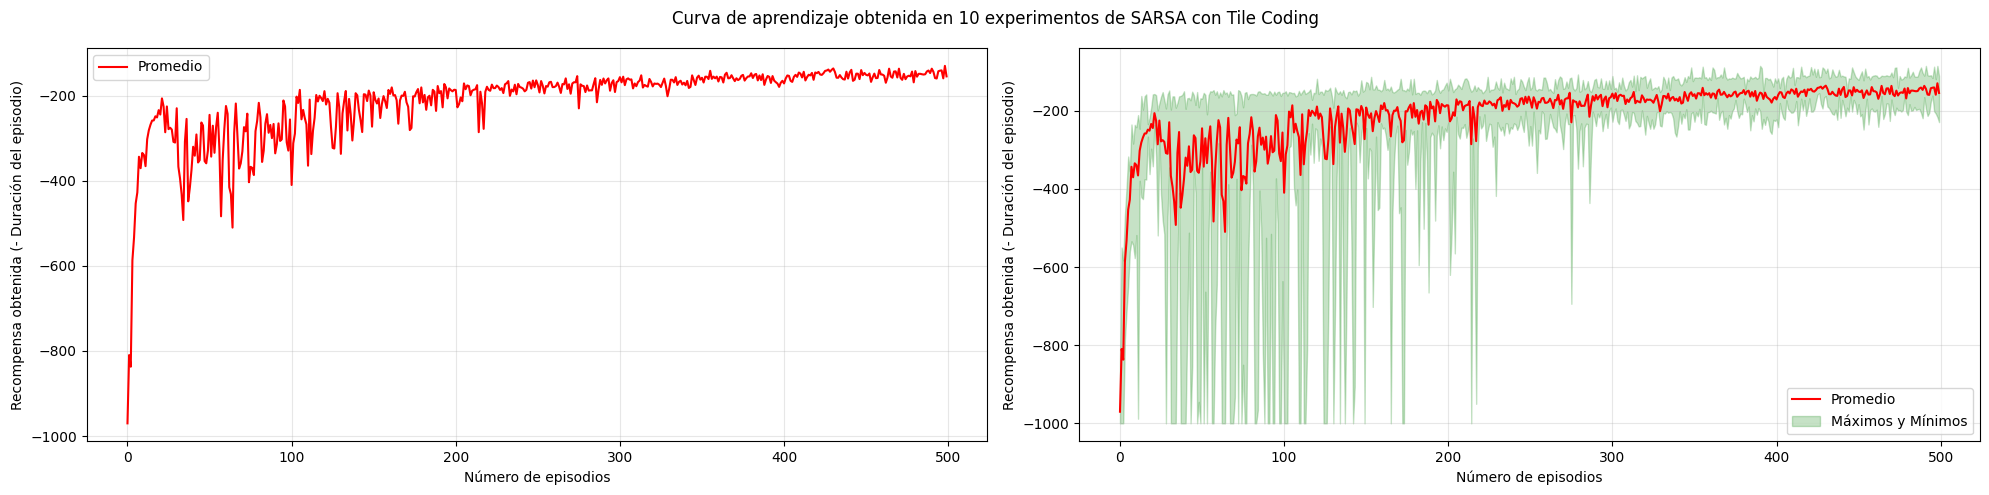

In [78]:
mean_rewards_Tiles = np.mean(all_rewards_Tiles, axis=0)  # Promedio por episodio
min_rewards_Tiles = np.min(all_rewards_Tiles, axis=0)  # Mínimo por episodio
max_rewards_Tiles = np.max(all_rewards_Tiles, axis=0)  # Máximo por episodio
episodes_Tiles = np.arange(len(mean_rewards_Tiles))  # Números de episodios
df_Tiles = pd.DataFrame({"x": episodes_Tiles, "min": min_rewards_Tiles, "max": max_rewards_Tiles}) #Organiza un DataFrame con los datos

#Realiza la gráfica
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
#Valores promedio
axs[0].grid(alpha=0.3)
axs[0].plot(episodes_Tiles, mean_rewards_Tiles, color='red', label="Promedio")
axs[0].set_ylabel('Recompensa obtenida (- Duración del episodio)')
axs[0].set_xlabel('Número de episodios')
axs[0].legend()
#Valores promedio, mínimos y máximos
axs[1].grid(alpha=0.3)
axs[1].plot(episodes_Tiles, mean_rewards_Tiles, color='red', label="Promedio")
axs[1].fill_between(df_Tiles["x"], df_Tiles["min"], df_Tiles["max"], color='green', alpha=0.225, label="Máximos y Mínimos")
axs[1].set_ylabel('Recompensa obtenida (- Duración del episodio)')
axs[1].set_xlabel('Número de episodios')
axs[1].legend()
number_of_experiments = len(all_rewards_Tiles)
plt.suptitle(f"Curva de aprendizaje obtenida en {number_of_experiments} experimentos de SARSA con Tile Coding")
plt.tight_layout()
plt.show()

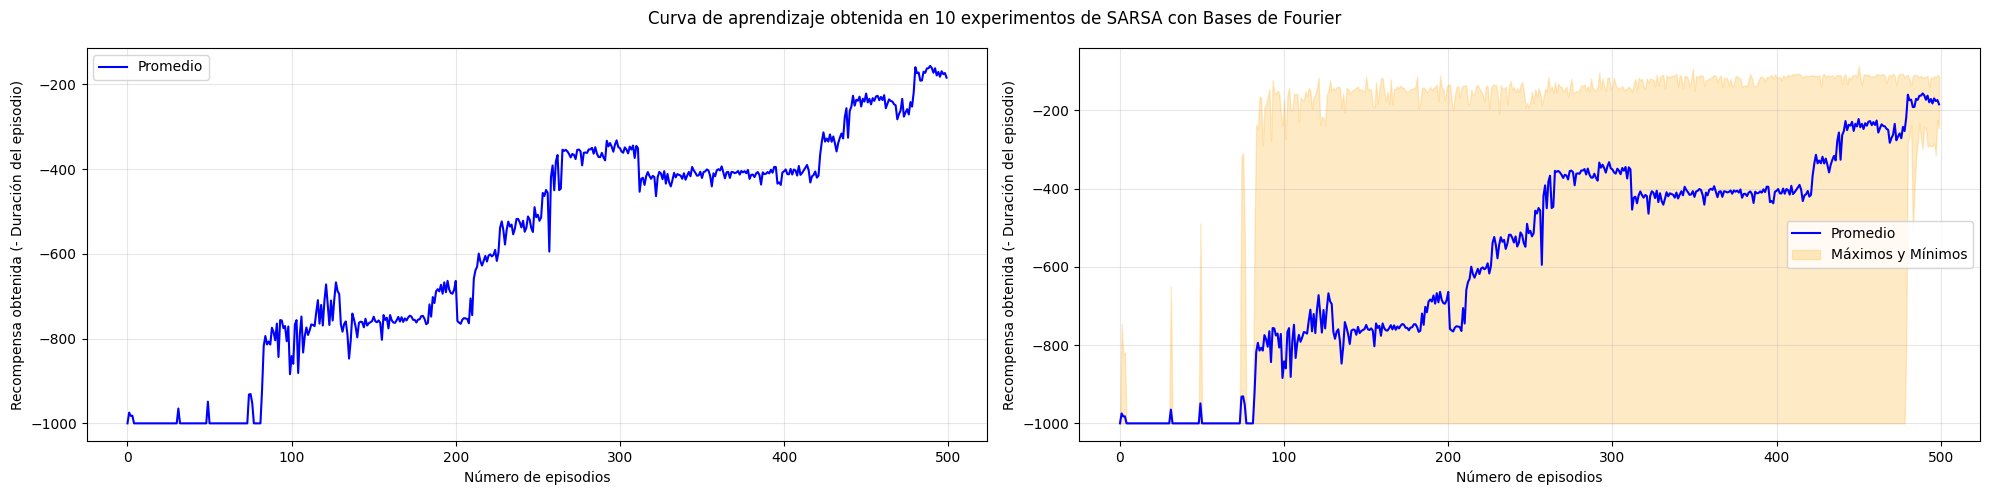

In [79]:
mean_rewards_Fourier = np.mean(all_rewards_Fourier, axis=0)  # Promedio por episodio
min_rewards_Fourier = np.min(all_rewards_Fourier, axis=0)  # Mínimo por episodio
max_rewards_Fourier = np.max(all_rewards_Fourier, axis=0)  # Máximo por episodio
episodes_Fourier = np.arange(len(mean_rewards_Fourier))  # Números de episodios
df_Fourier = pd.DataFrame({"x": episodes_Fourier, "min": min_rewards_Fourier, "max": max_rewards_Fourier}) #Organiza un DataFrame con los datos

#Realiza la gráfica
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
#Valores promedio
axs[0].grid(alpha=0.3)
axs[0].plot(episodes_Fourier, mean_rewards_Fourier, color='blue', label="Promedio")
axs[0].set_ylabel('Recompensa obtenida (- Duración del episodio)')
axs[0].set_xlabel('Número de episodios')
axs[0].legend()
#Valores promedio, mínimos y máximos
axs[1].grid(alpha=0.3)
axs[1].plot(episodes_Fourier, mean_rewards_Fourier, color='blue', label="Promedio")
axs[1].fill_between(df_Fourier["x"], df_Fourier["min"], df_Fourier["max"], color='orange', alpha=0.225, label="Máximos y Mínimos")
axs[1].set_ylabel('Recompensa obtenida (- Duración del episodio)')
axs[1].set_xlabel('Número de episodios')
axs[1].legend()
number_of_experiments = len(all_rewards_Fourier)
plt.suptitle(f"Curva de aprendizaje obtenida en {number_of_experiments} experimentos de SARSA con Bases de Fourier")
plt.tight_layout()
plt.show()

Después, se renderizan los videos de simulación donde cada agente aplica la política aprendida con base en la aproximación de la función $q(s,a,\mathbf{w})$ al final del entrenamiento.

In [86]:
# Se renderizan videos con las políticas aprendidas
agent_Tiles.video()
agent_Fourier.video()

Recompensa obtenida en el episodio del video (Tile Coding): -142.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  94%|█████████▍| 136/144 [00:00<00:00, 205.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1743686535.8953125.mp4, 720000 bytes wanted but 0 bytes read,at frame 143/144, at time 4.77/4.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Recompensa obtenida en el episodio del video (Bases de Fourier): -185.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Y por último, se puede realizar una gráfica de la <i>cost-to-go function</i> estimada con ambos métodos tras el entrenamiento. Esta función corresponde a $\text{max}_a\hat{q}(s,a,\mathbf{w})$, la cual en este caso siempre es negativa porque las recompensa obtenida en cada paso es -1, por lo que se grafica el negativo de la función.

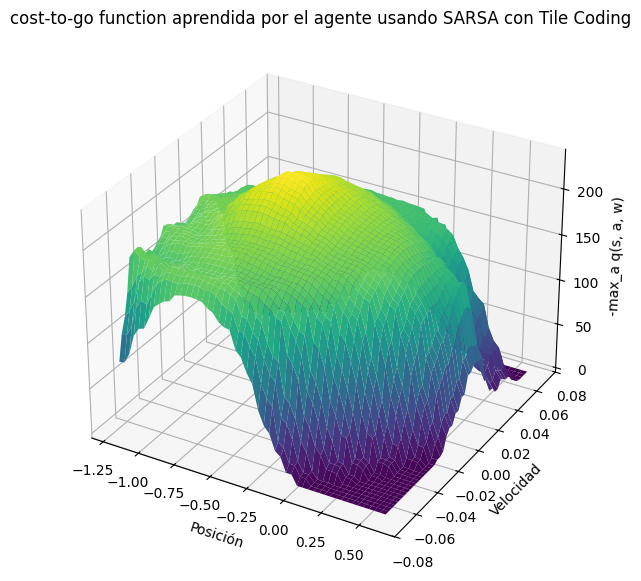

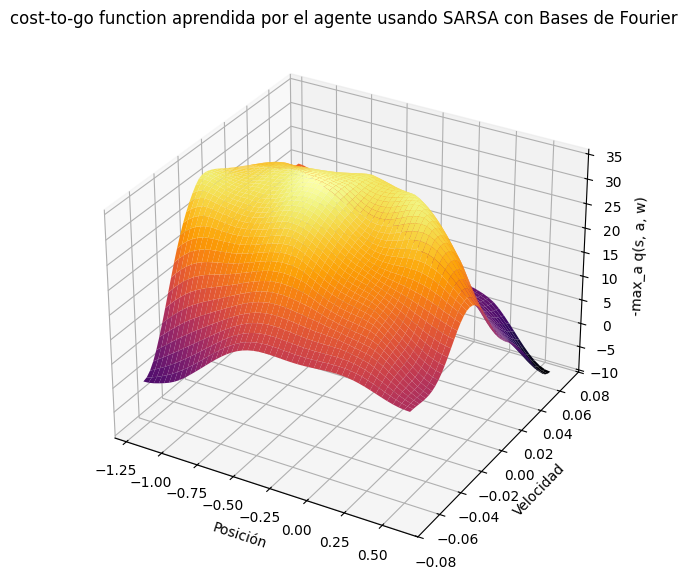

In [87]:
# Se grafican las cost-to-go functions obtenidas con ambos métodos de aproximación
agent_Tiles.graph_q()
agent_Fourier.graph_q()

## Ejercicio Práctico

Ahora que se demostró cómo se puede conducir un entrenamiento y análisis con el algoritmo de SARSA, itere en los entrenamientos variando algunos hiperparámetros del agente:


*   La Tasa de Aprendizaje ($\alpha$)
*   La Tasa de Exploración ($\epsilon$)
*   El Factor de Descuento ($\gamma)
*   La cantidad de <i>Tilings</i> y <i>Tiles</i>, en el caso de <i>Tile Coding</i>, y el orden de la aproximación de Fourier, en el caso de Bases de Fourier.

Puede tomar como referencia la gráfica de la Figura 10.2 del libro de Sutton y Barto [1] para enfocar sus pruebas y realizar una comparación efectiva.



In [84]:
#

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

In [85]:
#

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Reflexiones Finales

### **1. Resolución y generalización del espacio de estados**  
- ¿Cómo afecta el número de *tilings* (`num_tilings`) y el número de *tiles* (`num_tiles`) en la precisión y generalización del aprendizaje?  
- Si aumentamos el número de *tilings* pero mantenemos fijo el número de *tiles*, ¿qué efecto tendría en la calidad de la aproximación de la función de valor?  

### **2. Velocidad y estabilidad del aprendizaje**  
- ¿Cómo influye la tasa de aprendizaje (`alpha`) y los pesos iniciales (`initial_weights`) en la rapidez con la que el agente mejora su desempeño?  
- Si usamos un $\alpha$ demasiado alto o demasiado bajo, ¿cómo afectaría la estabilidad del aprendizaje?  

### **3. Exploración y toma de decisiones**  
- ¿Qué impacto tiene el parámetro de exploración (`epsilon`) en la estrategia del agente? ¿Cómo cambiaría su comportamiento si eliminamos la exploración $\epsilon = 0$?   

### **4. Tiempo de entrenamiento del agente**  
- ¿Cómo influye el tamaño de la tabla de *hashing* (`iht_size`) en el tiempo de entrenamiento del agente? ¿Un tamaño mayor siempre significa mejor rendimiento?  




# Referencias

[1] Sutton, R. S. and Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press, second edition.

[2] Gym Documentation, Mountain Car. `https://gymnasium.farama.org/environments/classic_control/mountain_car/`

[3] Sutton, R. S. Tile Coding Software -- Reference Manual, Version 3.0. Reinforcement Learning and Artificial Intelligence (RLAI). `http://incompleteideas.net/tiles/tiles3.html`


[4] MykeS96 en GitHub: "Episodic Mountain Car with function appoximation and control" (2020). `https://github.com/MikeS96/rl_openai/blob/master/Mountain%20Car.ipynb`